We use `notebooks/examples/1 - Make Channel Network` removing extraneous discussion and visualizations wherever possible. We also include a node attribute that uses the distance transform in a node's associated segment. This will be used to very roughly compare [RivGraph](https://github.com/jonschwenk/RivGraph/tree/master/rivgraph) and [ChanGeom](https://www.burchfisher.com/data.html)'s approach to measuring width.

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import networkx as nx
from orinoco import (get_distance_in_channel,
                     get_distance_segments,
                     get_undirected_channel_network,
                     direct_channel_network,
                     export_edges_to_geodataframe,
                     export_nodes_to_geodataframe,
                     get_map_centroid_from_binary_mask,
                     add_flow_attributes,
                     split_tuple_pairs,
                     get_segment_df,
                     get_geo_width_df,
                     update_graph_with_widths,
                     get_width_features_from_segments,
                     add_width_features_to_graph,
                     get_array_from_features
                     )
from skimage.color import label2rgb
import random
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm

# Initialize the Tile Directory

In [2]:
tile_name = 'NH15'

tile_dir = Path(f'out/{tile_name}')
tile_dir.exists()

True

# Read Data from the Tile Directory

In [3]:
with rasterio.open(tile_dir/f'water_mask_{tile_name}.tif') as ds:
    water_mask = ds.read(1)
with rasterio.open(tile_dir/f'ocean_mask_{tile_name}.tif') as ds:
    ocean_mask = ds.read(1)
    profile = ds.profile

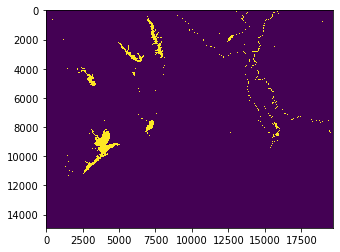

In [4]:
plt.imshow(water_mask, interpolation='none')

# Generate Orinoco Products

## Obtaining the Distance Function

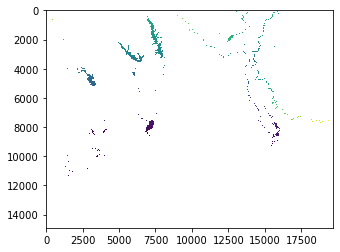

In [5]:
transform = profile['transform']
dx, dy = transform.a, -transform.e
dist = get_distance_in_channel(water_mask,
                               ocean_mask,
                               dx=dx,
                               dy=dy,
                               # removes areas with less than percentage of total size
                               min_rel_area=0.0,
                               # Applys a 1 pixel buffer for distance computation
                               # for artifical 8-connectivity.
                               # See: https://github.com/scikit-fmm/scikit-fmm/issues/32
                               # Removes buffer after computation complete.
                               # Only recommended for GRWL
                               apply_mask_buffer=True
                              )
plt.imshow(dist, interpolation='none')

Save the distance product.

In [6]:
p = profile.copy()
p['dtype'] = 'float32'
with rasterio.open(tile_dir/f'distance_{tile_name}.tif', 'w', **p) as ds:
    ds.write(dist.astype(np.float32), 1)

## Segmentation of the Channel

In [7]:
pixel_step = 5
segments, interface_adj_segments = get_distance_segments(dist,
                                                         pixel_step,
                                                         dx=dx,
                                                         dy=dy,
                                                         connectivity=8,
                                                         min_size=4)

rag neighbors: 100%|██████████| 1745/1745 [00:00<00:00, 24512.57it/s]


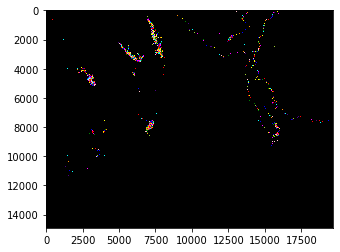

In [8]:
segments_rgb = label2rgb(segments, bg_label=0)
plt.imshow(segments_rgb, interpolation='none')

We save both the `segments` and the `segments_rgb` to disk.

In [9]:
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(tile_dir/f'segments_{tile_name}.tif', 'w', **p) as ds:
    ds.write(segments.astype(np.int32), 1)

p = profile.copy()
p['dtype'] = 'float32'
p['count'] = 3
with rasterio.open(tile_dir/f'segments_rgb_{tile_name}.tif', 'w', **p) as ds:
    ds.write(segments_rgb.transpose([2, 0, 1]).astype(np.float32))

## Obtaining the Undirected Network

In [10]:
chanG_undirected = get_undirected_channel_network(segments, 
                                                  dist, 
                                                  profile, 
                                                  interface_adj_segments,
                                                  connectivity=8)

adding edges: 100%|██████████| 33069/33069 [00:00<00:00, 125469.43it/s]


In [11]:
node_data = chanG_undirected.nodes(data=True)
[(node, data) for (node, data) in node_data if data['label'] == 268]

[((396100.0, 3541795.0),
  {'label': 268,
   'meters_to_interface': 364688.40625,
   'x': 396100.0,
   'y': 3541795.0,
   'interface_adj': False})]

## Obtaining the Directed Network

In [12]:
chanG = direct_channel_network(chanG_undirected, 
                               # The keywords below are how the pruning occurs
                               # Specifies pruning will be done
                               remove_dangling=True, 
                               # Do not prune nodes within 1 km of interface
                               interface_buffer_m=1_000,     
                               # Remove edge groups with an degree 1 endpoint and size <=3
                               group_min_size=3,
                               # How many times to do this pruning
                               dangling_iterations=1
                               )

Let's do a quick sanity check.

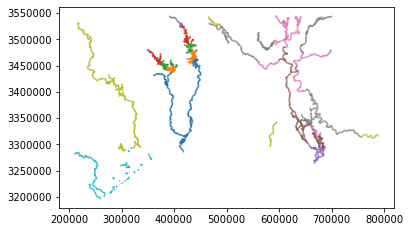

In [13]:
df_edges = export_edges_to_geodataframe(chanG, profile['crs'])
df_edges.plot(column='segment_id', categorical=True)

## Obtaining the Widths

### Using the distance transform

We are going to use the distance transform within a segment. We have a function that determines the width according to $2\cdot d - 1$ where d is the distance to the land mask according to the distance transform in a small 1-pixel buffer around the segment (if this is 0, we use the full distance transform on the channel mask).

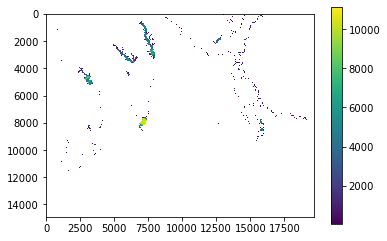

In [14]:
width_features = get_width_features_from_segments(segments, profile)
widths = get_array_from_features(segments, width_features)
plt.imshow(widths, interpolation='none')
plt.colorbar()

We now add these attributes to the graph.

In [15]:
chanG = add_width_features_to_graph(chanG, width_features.ravel())
node_data =dict(chanG.nodes(data=True))
random.choice(list(node_data.items()))

((607104.1304347826, 3461452.8260869565),
 {'label': 10955,
  'meters_to_interface': 269648.61478186015,
  'x': 607104.1304347826,
  'y': 3461452.8260869565,
  'interface_adj': False,
  'graph_degree': 2,
  'width_from_segment': 139.7056274847714})

### Using $\nabla \varphi$

We compute width using the gradient of the distance function (and possibly the network structure). First we obtain the orientation of along wich to obtain these measured widths (perpendicular to the artificial flow).

In [16]:
chanG = add_flow_attributes(chanG, dist, profile['transform'])

flow vector computation using network: 100%|██████████| 31377/31377 [00:02<00:00, 11006.29it/s]


To perform intersection, we must extract the polygons of the segments. This takes a bit of time to polygonize the segments, so be patient.

In [17]:
%%time

df_segments = get_segment_df(segments, chanG, profile, connectivity=8)
df_segments.head()

CPU times: user 30.5 s, sys: 1.31 s, total: 31.8 s
Wall time: 31.7 s


,label,geometry,perimeter,node,flow_vector_perp
0,1,"POLYGON ((391245 3544455, 391245 3544335, 3912...",360.0,"(391257.85714285716, 3544416.4285714286)","(0.8796713683883118, -0.4755820472198621)"
1,2,"POLYGON ((465375 3544455, 465375 3544425, 4654...",720.0,"(465490.0, 3544420.0)","(-0.88743865, -0.46092585)"
2,3,"POLYGON ((592365 3544455, 592365 3544425, 5923...",780.0,"(592450.3846153846, 3544380.0)","(-0.5367394, -0.8437481)"
3,4,"POLYGON ((594735 3544455, 594735 3544425, 5947...",780.0,"(594633.9473684211, 3544368.1578947366)","(0.27024899404439173, -0.9627904658948355)"
4,5,"POLYGON ((594765 3544455, 594765 3544425, 5947...",780.0,"(594810.7142857143, 3544400.714285714)","(-0.15792433984332827, -0.9874512154456285)"


We will save the geometries to a file for later inspection.

In [18]:
df_segments_out = split_tuple_pairs(df_segments)
df_segments_out.to_file(tile_dir/'segments.geojson', 
                        driver='GeoJSON')

/Users/cmarshak/anaconda3/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Now we extract the widths are associated geometry. This is the most expensive computation in the notebook, so be very patient. Could take 5 minutes or so.

In [19]:
%%time

df_geo_widths = get_geo_width_df(df_segments, chanG, radius=1)
df_geo_widths.head()

CPU times: user 2min 27s, sys: 515 ms, total: 2min 27s
Wall time: 2min 27s


,label,node,geometry,width_m
0,1,"(391257.85714285716, 3544416.4285714286)",LINESTRING (391305.000000001 3544390.941443715...,68.207290
1,2,"(465490.0, 3544420.0)",LINESTRING (465434.999999999 3544391.433606749...,137.910238
2,3,"(592450.3846153846, 3544380.0)",LINESTRING (592424.999999999 3544340.095680592...,136.183207
3,4,"(594633.9473684211, 3544368.1578947366)",LINESTRING (594651.6753768751 3544304.99999999...,93.478283
4,5,"(594810.7142857143, 3544400.714285714)",LINESTRING (594800.2045156846 3544334.99999999...,91.143743


Let's save the widths again for later inspection.

In [20]:
df_geo_widths_out = split_tuple_pairs(df_geo_widths)
df_geo_widths_out = df_geo_widths_out[~df_geo_widths_out.geometry.is_empty]
df_geo_widths_out.to_file(tile_dir/'width_geometries.geojson', 
                          driver='GeoJSON')

We update the node attributes. And we see all of the attributes we have added.

In [21]:
len(chanG)

31377

In [22]:
chanG = update_graph_with_widths(chanG, df_geo_widths)

node_data =dict(chanG.nodes(data=True))
random.choice(list(node_data.items()))

((560237.7272727273, 3507669.5454545454),
 {'label': 4500,
  'meters_to_interface': 467995.1620679836,
  'x': 560237.7272727273,
  'y': 3507669.5454545454,
  'interface_adj': False,
  'graph_degree': 2,
  'width_from_segment': 30.0,
  'flow_vector_perp_grad': None,
  'flow_vector_network': (-0.9972743380388851, 0.0737827533310022),
  'flow_vector_perp_network': (-0.0737827533310022, -0.9972743380388851),
  'flow_vector_perp': (-0.0737827533310022, -0.9972743380388851),
  'width_m': 30.081993346840136})

# Save Network

We now save the nodes and edges to `geojson` files and serialize the NetworkX `DiGraph` with `pickle`.

In [23]:
df_nodes = export_nodes_to_geodataframe(chanG, profile['crs'])
df_nodes = split_tuple_pairs(df_nodes)
df_edges = export_edges_to_geodataframe(chanG, profile['crs'])

In [24]:
df_edges.to_file(tile_dir/f'{tile_name}_edges.geojson', driver='GeoJSON')
df_nodes.drop(columns=['interface_adj']).to_file(tile_dir/f'{tile_name}_nodes.geojson', driver='GeoJSON')
nx.write_gpickle(chanG, tile_dir/f'{tile_name}_network.pkl')